In [1]:
from IPython.display import Image

# Introduction to ML using Text Classification
     High-level overview of the workflow used to solve Machine Learning problems:

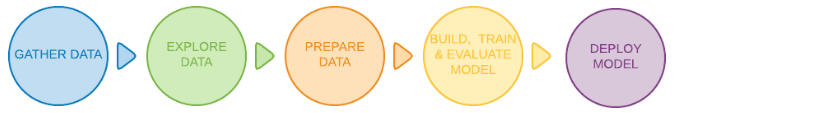

In [2]:
Image(filename='images/ML_steps.png')

# and Supervised Learning

    1.Learning from training data is called Supervided Learning. 
        a. Input: Training data
        b. Output: Prediction function that produces output Y given input X

In [3]:
import os
import _pickle as cPickle

import numpy  as np
import matplotlib.pyplot as plt; plt.rcdefaults()

from collections             import Counter

from sklearn import svm

from sklearn import tree

from sklearn.naive_bayes     import MultinomialNB
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression


from sklearn.metrics         import accuracy_score
from sklearn.model_selection import train_test_split as tts
from sklearn.feature_extraction.text import CountVectorizer

# Problem Statement

Classify different types of emails into to categories (Spam or Not-Spam) based on their features using supervised learning

## Exaple

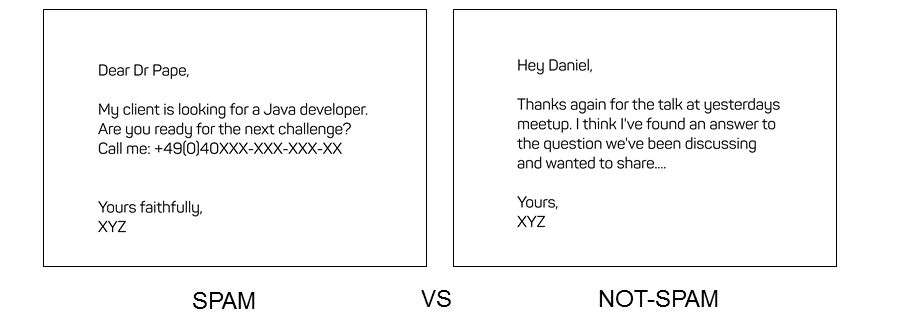

In [4]:
Image(filename='images/spam_not_spam.png')

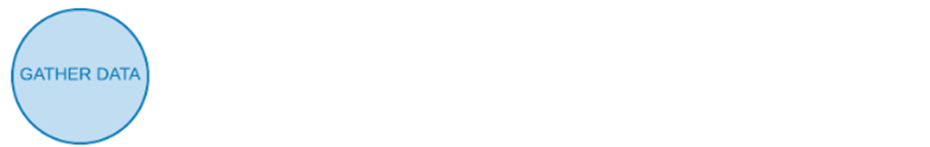

In [5]:
Image(filename='images/gather.png')

Gathering data is a important task in solving supervised Machine Learning (ML) problems because the ML models can only be as good as the dataset is built from. Because of that, the dataset selected for fix the spam or not-spam problem is a well-documented collection of emails classified as spam or ham from the Iran University of Science and Technology. That is available at: http://www2.aueb.gr/users/ion/data/enron-spam/

In [6]:
direc = "dataset/"
files = os.listdir(direc)
texts = [direc + file for file in files]

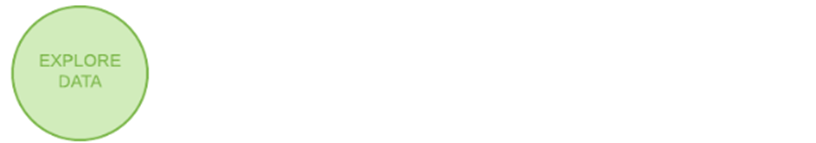

In [7]:
Image(filename='images/explore.png')

# Data example

In [8]:
texts[0:9]

['dataset/0000.1999-12-10.farmer.ham.txt',
 'dataset/0001.1999-12-10.farmer.ham.txt',
 'dataset/0002.1999-12-13.farmer.ham.txt',
 'dataset/0003.1999-12-14.farmer.ham.txt',
 'dataset/0004.1999-12-14.farmer.ham.txt',
 'dataset/0005.1999-12-14.farmer.ham.txt',
 'dataset/0006.2003-12-18.GP.spam.txt',
 'dataset/0007.1999-12-14.farmer.ham.txt',
 'dataset/0008.2003-12-18.GP.spam.txt']

# An example of a not-spam email

In [9]:
file = open(texts[0])
text = file.read().replace('\n',' ')

text

"Subject: ua 4 - meter 1441 for 11 / 97 - falfurrias daren - i need your help in resolving this issue . there wasn ' t any deal in oss for the above reference meter , nor could i find anything in cpr . the contract shows 089 - 41500 - 102 representing a sale in the amount of 9448 . thanks , stella"

# An example of a spam email

In [10]:
file = open(texts[7])
text = file.read().replace('\n',' ')

text

'Subject: mcmullen gas for 11 / 99 jackie , since the inlet to 3 river plant is shut in on 10 / 19 / 99 ( the last day of flow ) : at what meter is the mcmullen gas being diverted to ? at what meter is hpl buying the residue gas ? ( this is the gas from teco , vastar , vintage , tejones , and swift ) i still see active deals at meter 3405 in path manager for teco , vastar , vintage , tejones , and swift i also see gas scheduled in pops at meter 3404 and 3405 . please advice . we need to resolve this as soon as possible so settlement can send out payments . thanks'

# Loading (not-empty) files  

Computers are great at working with structured data like tables, but humans usually communicate in words, not in tables. Then, it is necessary to convert words into values for computers understand, as also for ML models be capable to learn, and because of that we'll not loading emptly files. We need words to be converted them into values.

In [11]:
def load_text(dataset):

    def read_file(file):
        try:
            f = open(file)
            load = f.read()

            if load != None:
                return load
            else: return None
            
        except: return None
        # or print('encoding error type detected in the: {}'.format(file))
        
    loads = []
    for file in texts: 
        f = read_file(file)

        if f == None: pass
        else: loads.append(f)
            
    return loads

# Key Metrics

Collecting metrics could be very helpful for the feature engineering process and also for us understand the type of data that we are working with. Here are some key  useful  metrics that we'll look at:

    1. Number of samples: total of examples in the dataset.
    2. Number of samples by category (Spam, Not-Smap)
    3. Frequency distribution of words (which helps to identify how important a word in the dataset)       
    4. Distribution of sample length: number of words per sample (which helps to create a vocabulary of words)

# 1. Number of samples

In [12]:
print('1. Number of samples: {}'.format(len(texts)))

1. Number of samples: 5174


# 2. Number of samples by category

In [13]:
ham = [data for data in texts if data.endswith('ham.txt')]

In [14]:
print('Number of Not-Spam emails: {}'.format(len(ham)))
print('Number of Spam emails: {}'.format( len(texts) - len(ham)))

Number of Not-Spam emails: 3672
Number of Spam emails: 1502


In [15]:
def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',
    }
    vectorizer = CountVectorizer(**kwargs)

    vectorized_texts = vectorizer.fit_transform(sample_texts)

    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.figure(figsize=(20,10))
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('Words')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of words')
    plt.xticks(idx, ngrams, rotation=45)
    
    plt.show()

# 3. Frequency distribution of words

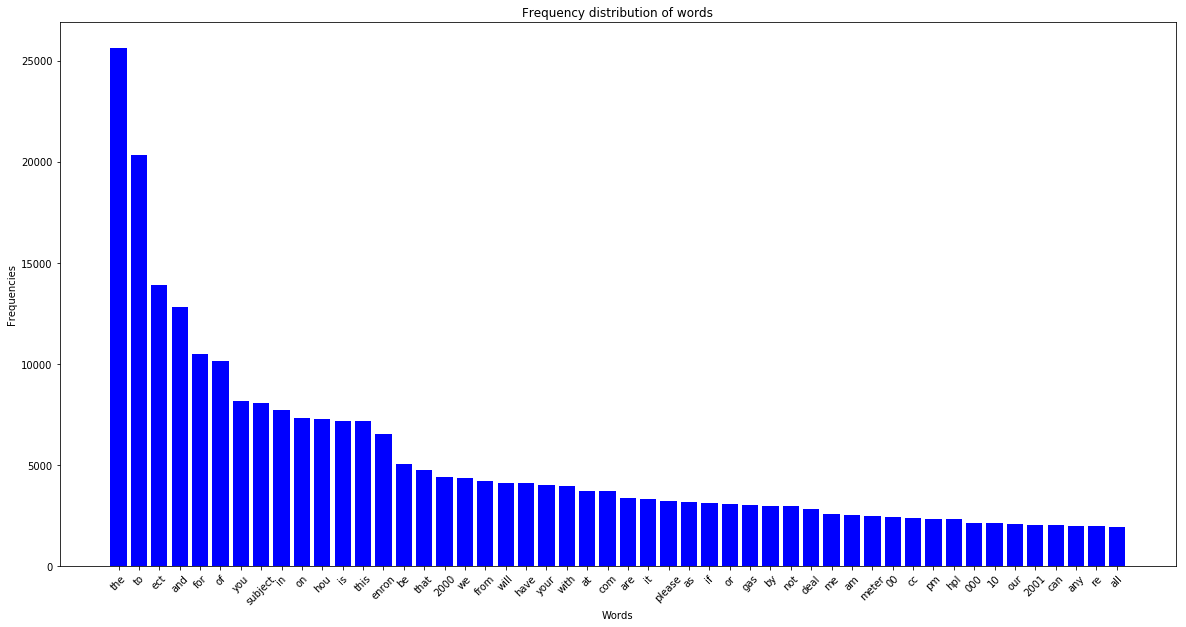

In [16]:
plot_frequency_distribution_of_ngrams(load_text(texts))

Looking at each word in the dataset we can see that a lot of filler words appear very frequently like “to”, “the”, and “is”. When we are doing statistics on text, these words can introduce noise since they appear more frequently than other words. So, to avoid that we can use Natural Language Processing to flag them. Then, we can remove it from our dataset. Altough, in this case we'll simplify it into just one line of code to delete the folowing more frequent stop words: "the", "to", "ect", "and", "for" and "of".  

In [17]:
def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    
    plt.figure(figsize=(20,10))
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples (emails)')
    plt.title('Sample length distribution (number of carateceters per sample)')
    plt.show()

# 4. Distribution of sample length

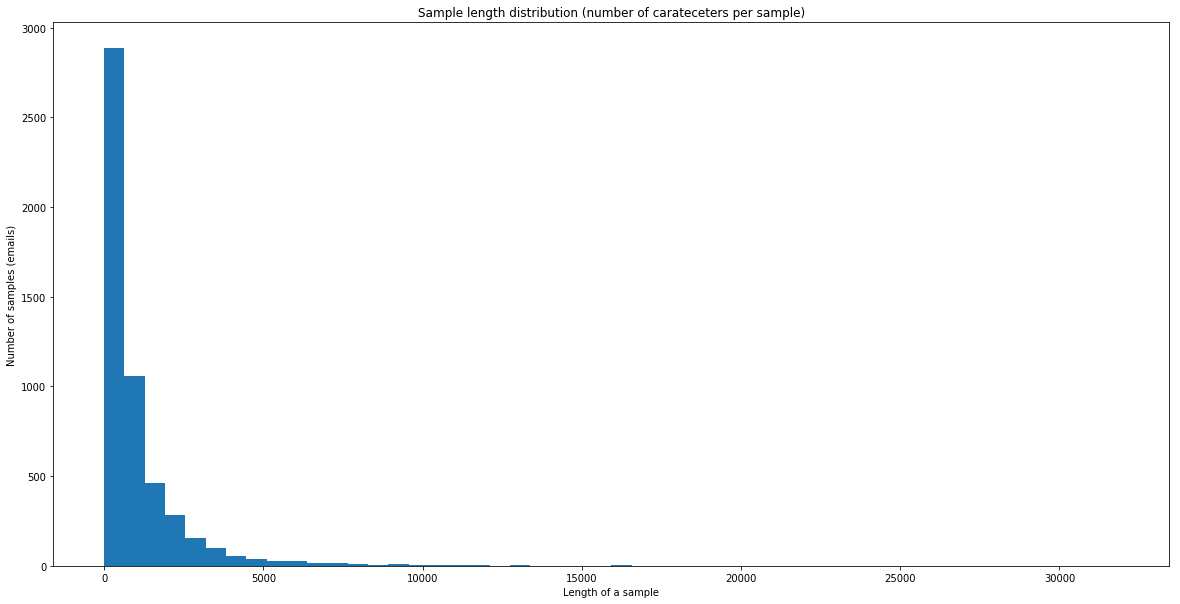

In [18]:
plot_sample_length_distribution(load_text(texts))

We can use this infomation in order to simplify the process of selecting a text classification model to find the algorithm that achieves the maximum accuracy while minimizing computation time required for training. 
    
How?
    
First, we can see that the majority of our sample has a length equal to or less than of 10000 characters. Second, kowning that the average of letterts in a word in English is 5 letters (http://www.ravi.io/language-word-lengths) we can divide this by 5, and build a vocabulary over the dataset selecting the most 2000k common words in the dataset. 
    
Then, we'll able to create a consistent training data and test it in differents ML models for text classification reducing the time consumed

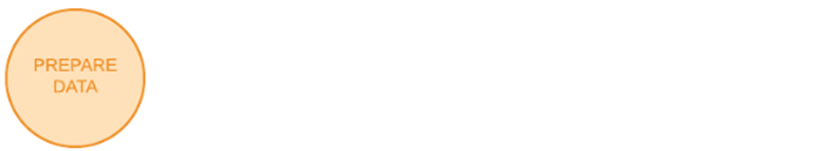

In [19]:
Image(filename='images/prepare.png')

# Preprocessing and Vectorization

This step is the answer for the following question: How to present text-data to an algorithm that expects numeric input?

# 1. Using Feature engineering

A Transformation of raw data into features suitable for modeling. Which means: transform texts into numeric input.
# Workflow

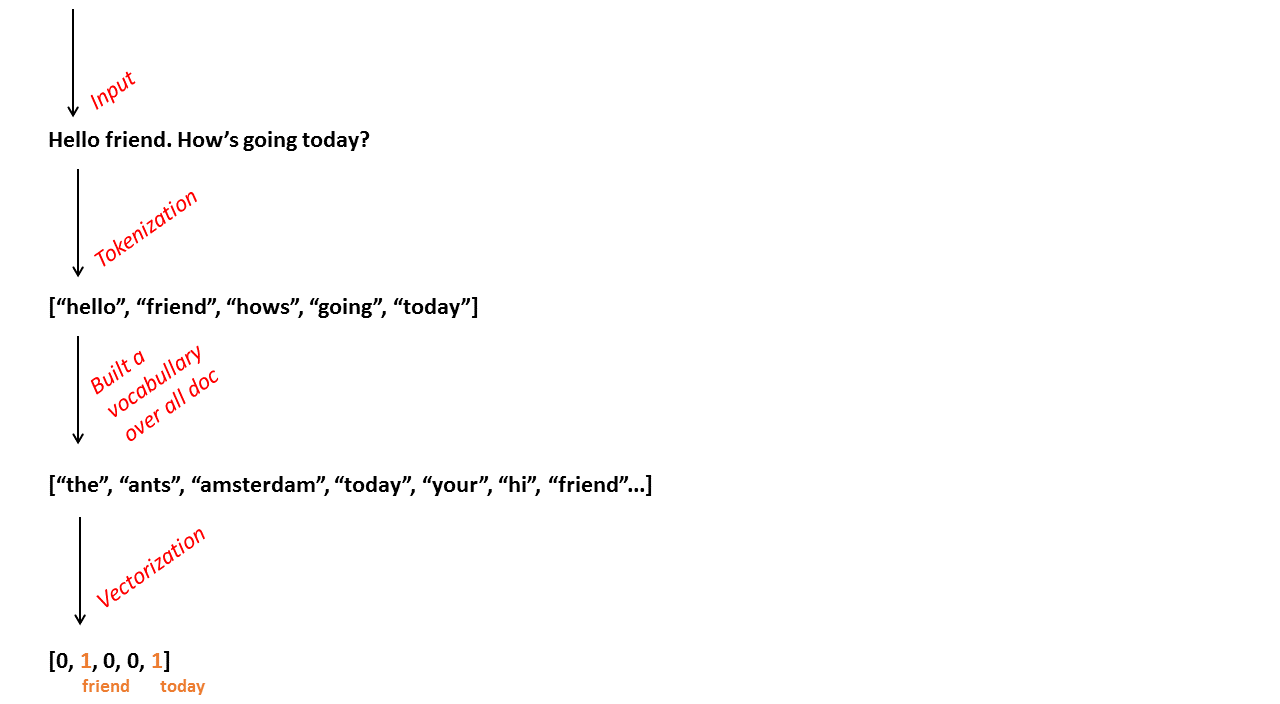

In [20]:
Image(filename='images/feature_engineering.png')

    
# Step-by-Step

## 1. Tokenization

The process to divide the text-data into a "list of formated words". 

In [21]:
ngrams   = []

for file in texts:
    
    f = open(file)
    
    try:
        data = f.read()
    except: pass
    
    ngrams += data.split(" ")

#  * Top 10 commom words into the dataset

In [22]:
for word in range(len(ngrams)):
    if not ngrams[word].isalpha():
        ngrams[word] = ""
vector = Counter(ngrams)
del vector[""]

In [23]:
vector.most_common(2000)[0:10]

[('the', 21967),
 ('to', 16094),
 ('ect', 11643),
 ('and', 11323),
 ('for', 9434),
 ('of', 9361),
 ('a', 8809),
 ('you', 7284),
 ('hou', 7283),
 ('in', 6870)]

## 2. Build a vocabulary over all doc

    1. Delete non alphabetic records
    2. Delete stop words ("the", "to", "ect", "and", "for", "in", "and", "of")
    3. Select the most 2000 common words 

In [24]:
def vectors():
    
    direc = "dataset/"
    files = os.listdir(direc)
    texts = [direc + file for file in files]

    ngrams   = []
    
    for file in texts:

        f = open(file)

        try:
            data = f.read()
        except: continue

        ngrams += data.split(" ")
    
    stop_words = ["the", "to", "ect", "and", "for", "in", "and", "of"]
    
    for word in range(len(ngrams)):
        if not ngrams[word].isalpha() or ngrams[word] in stop_words:
            ngrams[word] = ""
        
    vector = Counter(ngrams)
    del vector[""]

    return vector.most_common(2000)

## 3. Vectorization
Transformation of words to an array of numeric values of semantic or contextual information that computer can understand.

In [25]:
def vectorize(vectors):
    
    direc = "dataset/"
    files = os.listdir(direc)
    texts = [direc + file for file in files]
    
    labels = []
    feature_set = []

    for file in texts:
        
        data = []
        
        try:
            f = open(file)
            words = f.read().split(' ')
        except: continue
   
        for row in vectors:
            data.append(words.count(row[0]))
        feature_set.append(data)

        if "ham" in file:
            labels.append(0)
        if "spam" in file:
            labels.append(1)

    return feature_set, labels

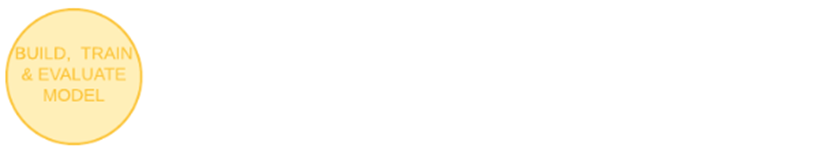

In [26]:
Image(filename='images/build.png')

### 1. What type of model should be used?

To know that it will be compared in terms of accuracy the 5 most popular and accurate Machine Learning algorithms for text classification problems. They are: 

    1. Naive Bayes 
    2. Decision Tree
    3. Support Vector Machines
    4. Random Forest
    5. Logistic Regression

### A few example of applications using ML classification algorithms are:

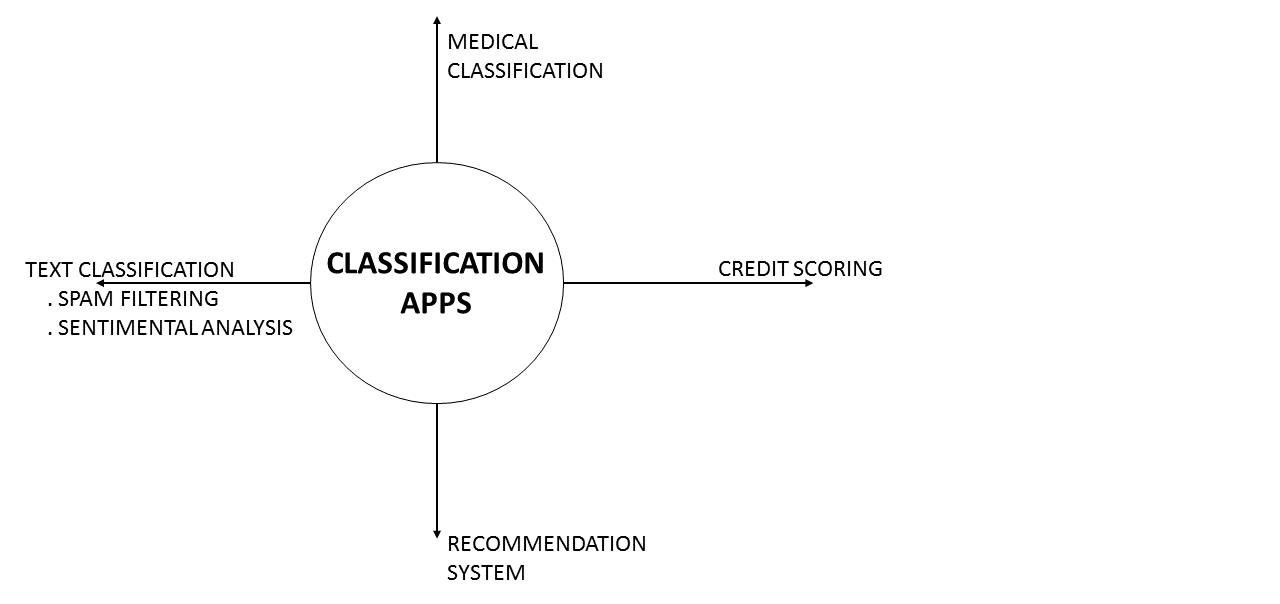

In [27]:
Image(filename='images/classification_apps.png')

### 2. Where the sources come from?

1. Text Categorization with Support Vector Machines: Learning with Many Relevant Features (Joachims, Universit at Dortmund, Germany, 1998) 
http://www.cs.cornell.edu/~tj/publications/joachims_98a.pdf

2. Comparison of Naive Bayes, Random Forest, Decision Tree, Support Vector Machines, and Logistic Regression Classifiers for Text Reviews Classification. (Pranckevicius; Marcinkevicius,  Vilnius University, Institute of Mathematics, Lithuania, 2017)
https://www.bjmc.lu.lv/fileadmin/user_upload/lu_portal/projekti/bjmc/Contents/5_2_05_Pranckevicius.pdf

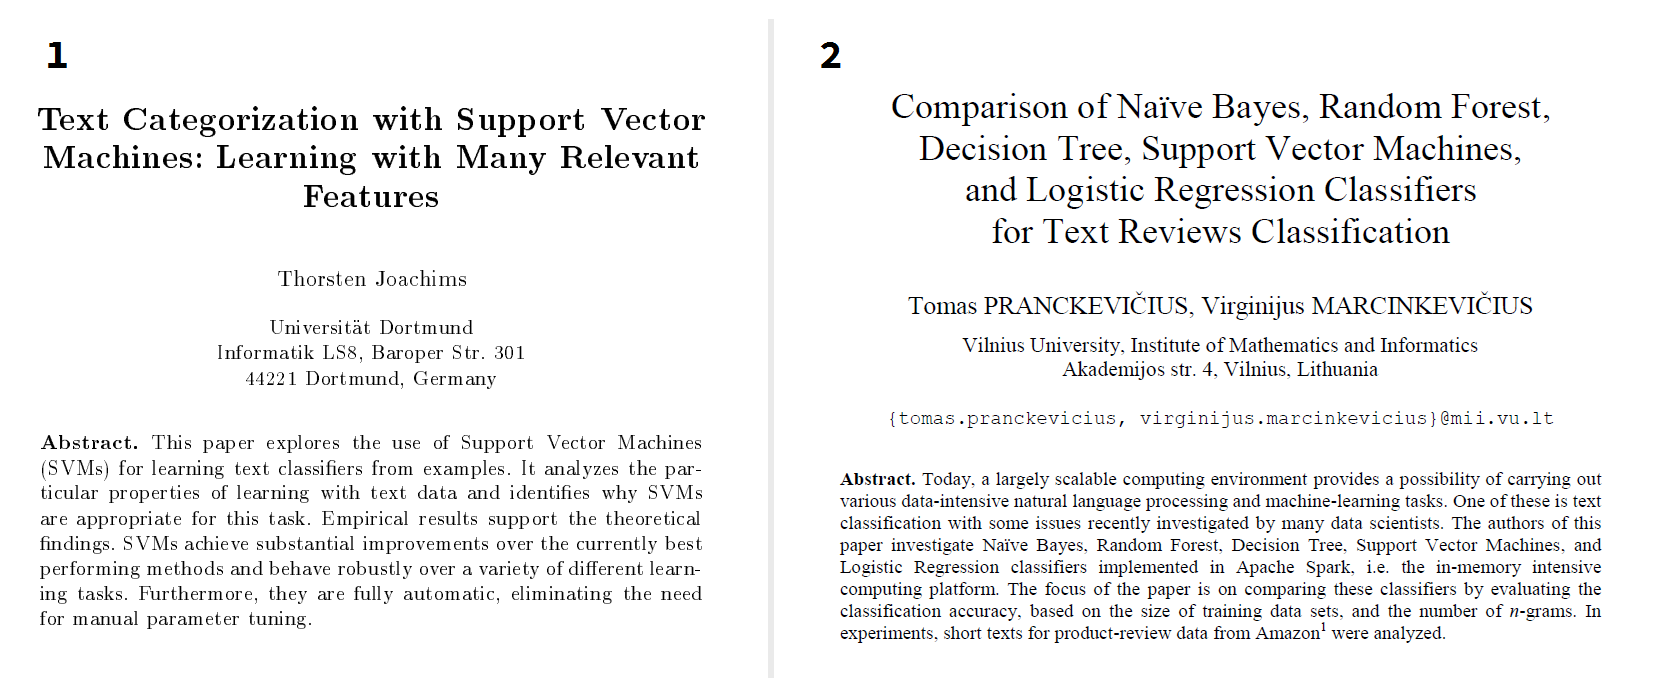

In [28]:
Image(filename='images/papers.png')

# 1. Naive Bayes
    
It is a probabilistic classifier that learns the probability of an object with certain features belonging to a particular group in class. 

    
# How does Naive Bayes work?

Based on the Bayes Theorem which gives the conditional probability of an event A given B. It is used to know which are the chances of certain events occur due to other events

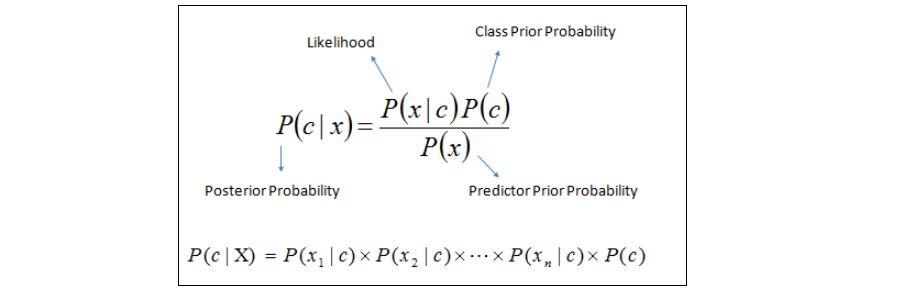

In [29]:
Image(filename='images/naive_2.png')

Bayes Theorem basically calculates the conditional probability of the occurence of an event based on prior knowledge of conditions related to the event

# 2. Decison Tree

Decision Tree is a tree shaped diagram used to determine a course of action. Each branch of a tree represents a possible decision
    
    
# How does Decision Tree work?

Example


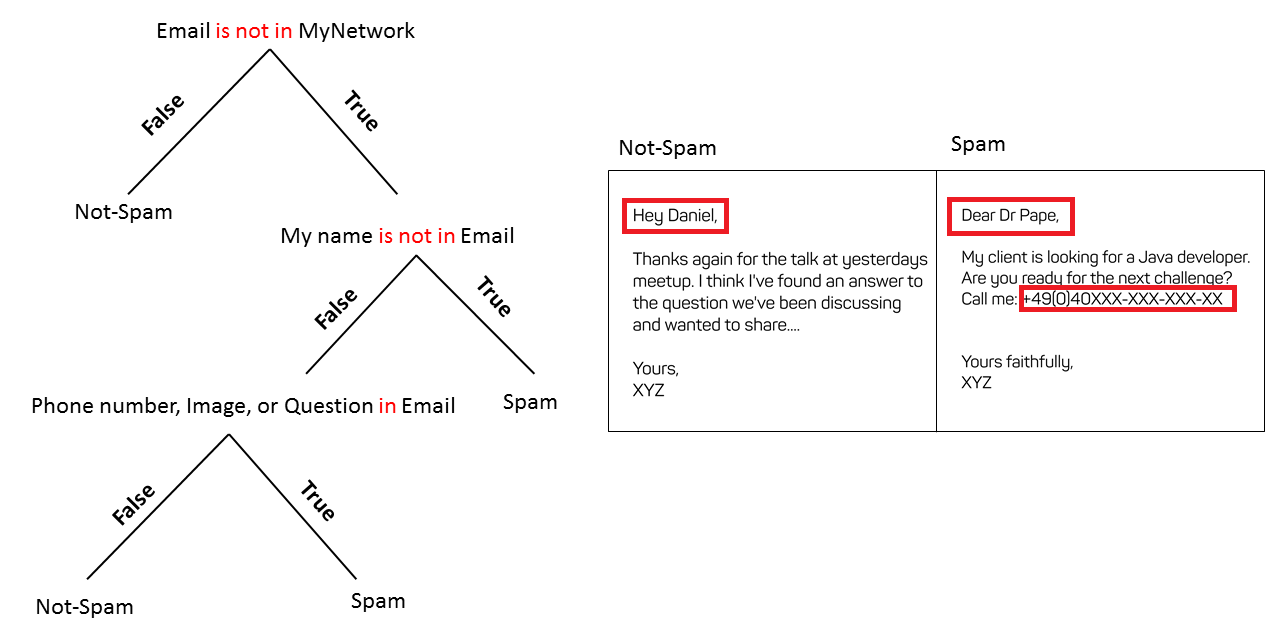

In [30]:
print('Example')
Image(filename='images/tree.png')

# 3. Random Forest
Random Forest is a collection of Decision Trees that operates by constructing multiple Decison Trees during training phases. The decision of the majority of the trees chosen by the random forest will be the final decision 

# How does Decision Tree work?

Example


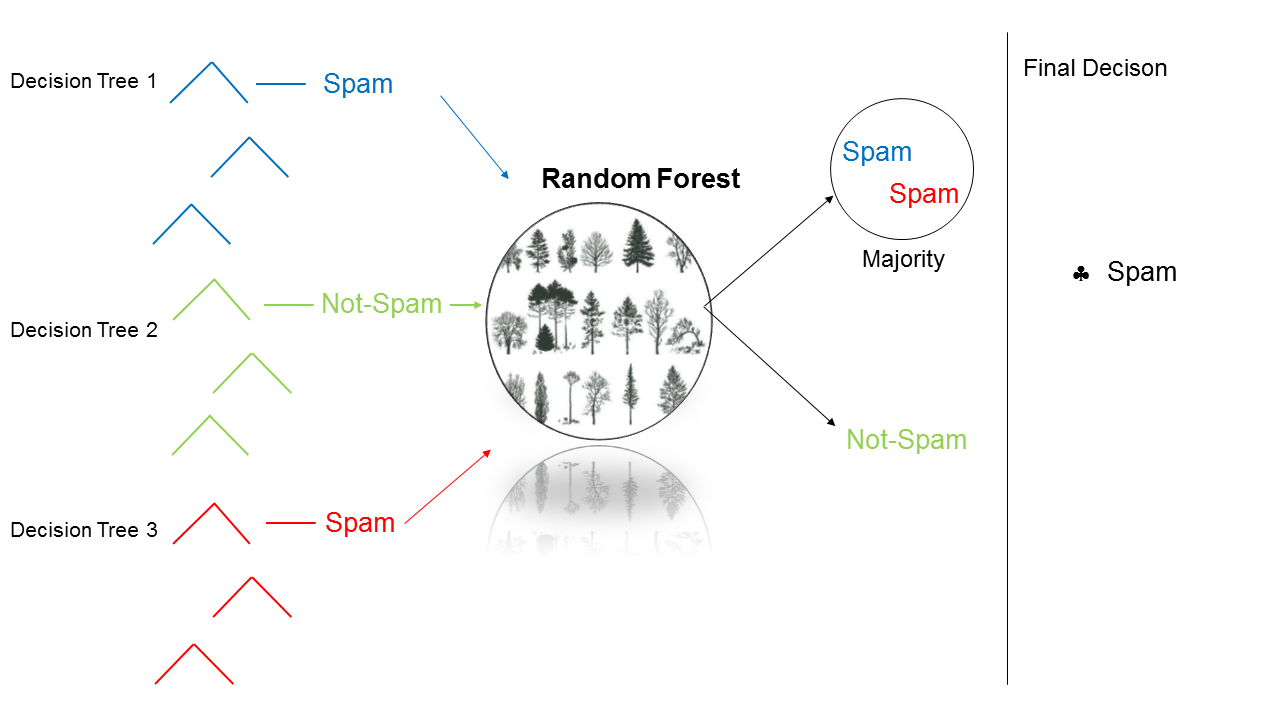

In [31]:
print('Example')
Image(filename='images/random_forest.png')

# 4. Support Vector Machines 

Suppor Vector Machines or SVM. It looks the extremes of the data sets and draws a decision boundary (Hyper-Plane) near to the extreme points in the dataset. 


# How does Linear Support Vector Machines (LSVM) work?

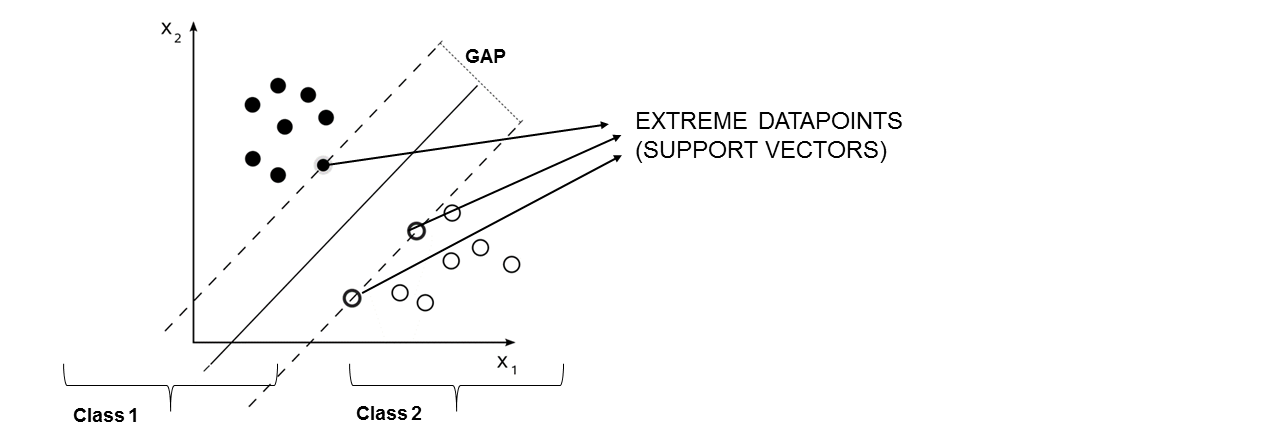

In [32]:
Image(filename='images/svm_1.png')

Essentially, SVM algorithm is a frontier which best segragates the classe 1 of classe 2 (Hyper-Plane/Line)

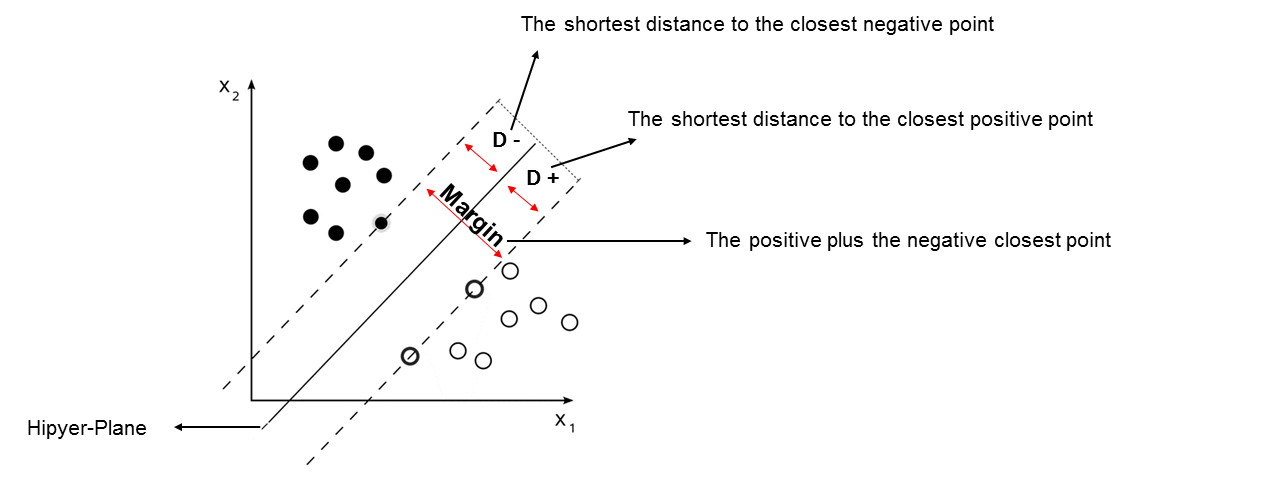

In [33]:
Image(filename='images/svm_2.png')

# 5. Logistic Regression 


1. It can hadle complex non-linear datasets 
2. It is efficient and does not require to much computational resources 
3. It has low varience. That is, less prone to over-fitting
    

# How does Logistic Regression work?

Logistic Regression measures the relationship between the category (labels) and one or more records (features) by estimating probabilities using it’s underlying logistic function. These probabilities must then be transformed into binary values in order to make a prediction.
    
## Logistic Regression steps

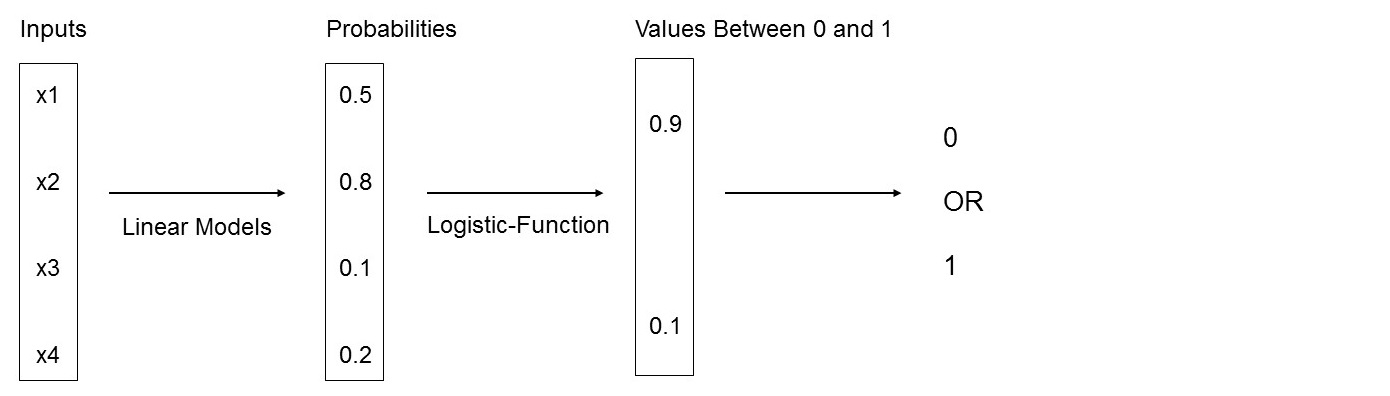

In [34]:
Image(filename='images/logistic_regression_1.png')

## Logistic Function
It is an S-shaped curve that can take any real-valued number and map it into a value between 0 and 1, but never exactly at those limits

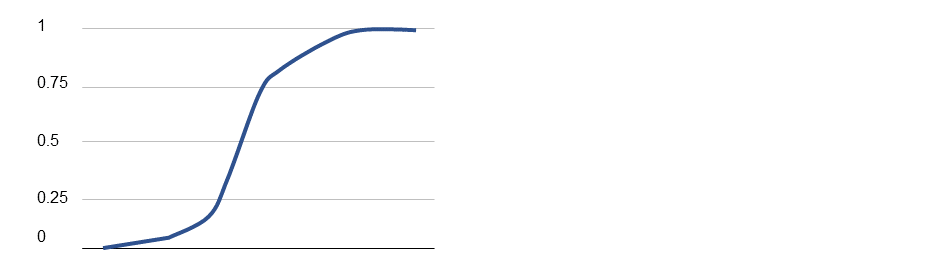

In [35]:
Image(filename='images/logistic_function.png')

## Linear Regression x Logistic Regression  

Linear Regression provides as output a continuous value. Example: a model that predicts the value of a property. The property's value might be different based on the property's characteristics like location and/or size. On the other hand, a discrete outcome will be 1 or 0. Yes or No. Because of that, we can use Logistic Regression for text classification problems as to predict if it (text-email) is a Spam (1) or a Not-Spam (0) email

# * Going through the first 4 steps of ML workflow

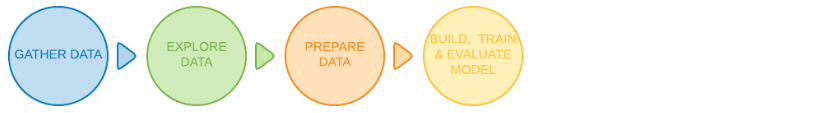

In [36]:
Image(filename='images/ML_steps_2.png') 

## 1. Get data

In [37]:
data = vectors()

## 2. Explore data

In [38]:
stop_words = ["the", "to", "ect", "and", "for", "in", "and", "of"]

In [39]:
load_data = load_text(texts)
load_data_clean = []
for i, word in enumerate(load_data):
    
    x = load_data[i]
    for stop in stop_words: 
        x = x.replace(stop, '')
    load_data_clean.append(x)

## 2.1 Frequency distribution of word

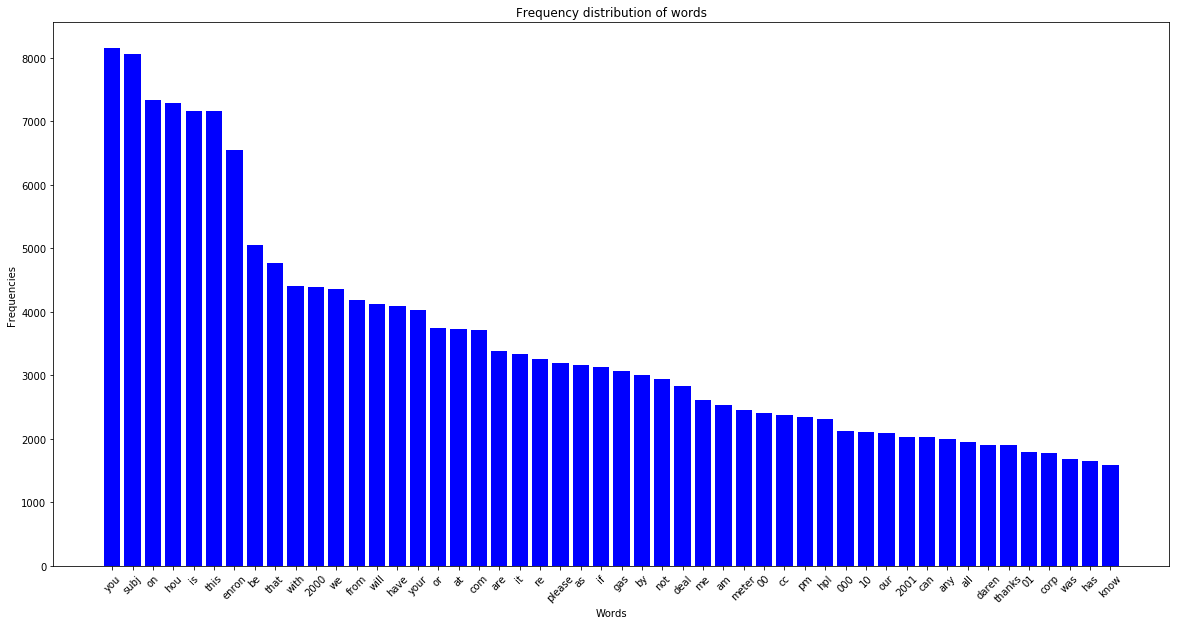

In [40]:
plot_frequency_distribution_of_ngrams(load_data_clean)

We can see a better distribution of words in our dataset because we have clened up the most frequent stop words as the', 'to', 'ect', 'and', 'for', 'and', 'of' 

## 3. Prepare data (Feature extraction)

In [41]:
features, labels = vectorize(data)

## 4. Build, Train, and Evaluate the Model 

    4.1 Splitting lebeled data into training and test sets

In [42]:
feature_train, feature_test, labels_train, labels_test = tts(features[:-1], labels, test_size=0.2)

    4.2 Getting/Choosing the ML algorithm

In [43]:
naive_bayes             = MultinomialNB()
decision_tree           = tree.DecisionTreeClassifier()
random_forest           = RandomForestClassifier()
logistic_regression     = LogisticRegression()
support_vector_machines = svm.SVC(kernel='linear')

    4.3 Training the ML model

In [44]:
tree     = decision_tree.fit(feature_train, labels_train)
naive    = naive_bayes.fit(feature_train, labels_train)
forest   = random_forest.fit(feature_train, labels_train)
support  = support_vector_machines.fit(feature_train, labels_train)
logistic = logistic_regression.fit(feature_train, labels_train)

    4.4 Evaluating the model (predction function) on a test set using:
    
        1. Naive Bayes
        2. Support Vector Machines
        3. Logistic Regression
        4. Decision Tree
        5. Random Forest

In [45]:
def score(classifier):
    preds = classifier.predict(feature_test)
    print ('The ML model accuracy score is: {}'.format(int(accuracy_score(labels_test, preds) * 100)))
    return int(accuracy_score(labels_test, preds) * 100)

def plot_score(Naive_Bayes, Decison_Tree, Random_Forest, Support_Vector_Machine, Logistic_Regression):
    
    objects = ('Naive_Bayes', 'Support_Vector_Machine', 'Logistic_Regression', 'Decison_Tree', 'Random_Forest')
   
    y_pos = np.arange(len(objects))

    performance = [Naive_Bayes, 
                   Decison_Tree, 
                   Random_Forest, 
                   Support_Vector_Machine, 
                   Logistic_Regression]

    plt.figure(figsize=(20,7))
    plt.bar(y_pos, performance, align='center', alpha=0.8, color='b')
    plt.xticks(y_pos, objects)
    plt.ylabel('Percentage')
    plt.title('ML Models Accuracy for Text Classification using a samp and not-spam dataset')

    plt.show()

# ML Models Evaluation

The ML model accuracy score is: 94
The ML model accuracy score is: 96
The ML model accuracy score is: 97
The ML model accuracy score is: 93
The ML model accuracy score is: 94


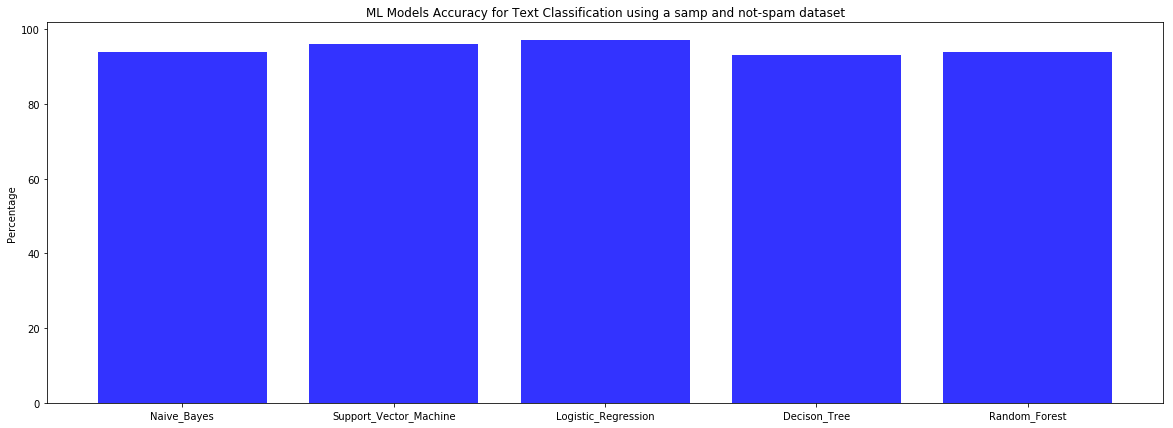

In [46]:
plot_score(score(naive), score(support), score(logistic), score(tree), score(forest)) 

The Logistic Regression model produce the best accuracy value: 97%. Although, the other models has been performing good as well: Support Vector Machines 96%. Naive Bayes 94%. Random Forest 94%. Decison Tree 93%. Knowing that the Logistic Regression has 97% of accuracy and that it is an efficenty model (does not require high computational resources) with low probabilty of overfitting. The Spam Dector App will take this model to predict if a email-text is Spam or Not-Spam

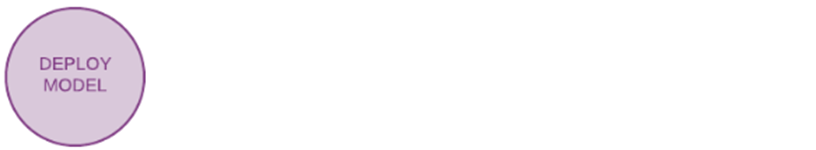

In [47]:
Image(filename='images/deploy.png')

    1. Deploy the ML model: The process of translating data structures or object into a format that can be stored 
    2. Load the Logistic Regression model saved in a file.md
    3. Run app: Detecte if a email-text is a spam or a not-spam email

In [48]:
def save(classifier, name):
    with open(name, 'wb') as fp:
        cPickle.dump(classifier, fp)
    print ("The classifer is saved!")
    
def load(classifier):
    
    with open(classifier, 'rb') as fp:
        classifier = cPickle.load(fp)
    return classifier

# Machile Learning model storage workflow (serealization)

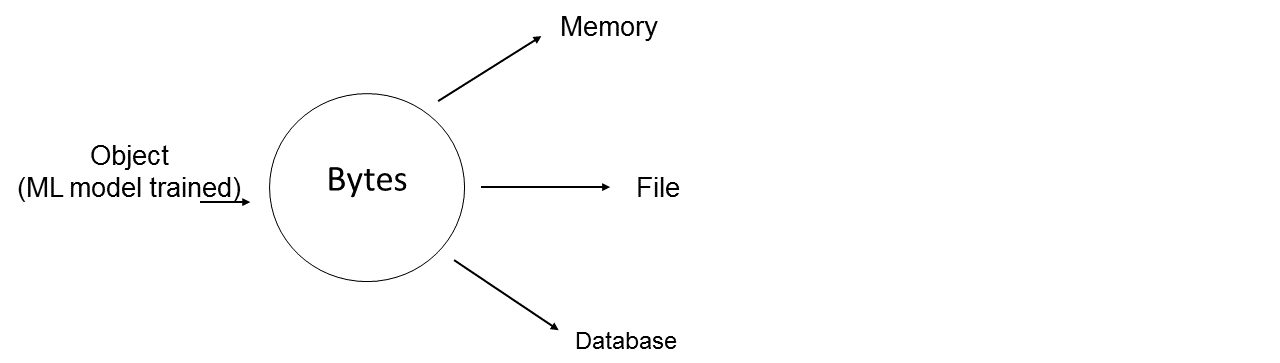

In [49]:
Image(filename='images/ml_serealization.png')

# 1. Deploying the model

In [50]:
def main():

    data = vectors()
    
    # Feature extraction
    features, labels = vectorize(data)

    # Splitting lebeled data into training and test sets
    feature_train, feature_test, labels_train, labels_test = tts(features[:-1], labels, test_size=0.2)
    
    # Choosing the ML algorithm
    classifier = LogisticRegression()
    
    # Training the ML model
    classifier.fit(feature_train, labels_train)
    
    # Evaluating the predction function on a test set
    preds = classifier.predict(feature_test)
    print ('The ML model accuracy score is: {}'.format(int(accuracy_score(labels_test, preds) * 100 ) ))
    
    # Serialization: Storing data / putting the classifier in production 
    save(classifier, "text_classifier.mdl")

In [51]:
if __name__ == "__main__":
    main()

The ML model accuracy score is: 96
The classifer is saved!


# * Solution
    1. Predict if a text is a spam or not-spam

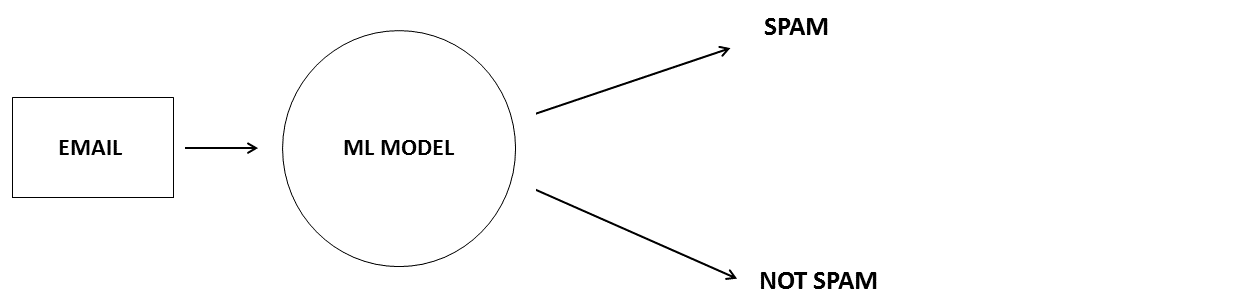

In [52]:
Image(filename='images/detector.png') 

# 2. Loading the model

In [53]:
def detector():
    
    vector     = vectors()
    classifier = load("text_classifier.mdl")

    while True:

        features = []

        inp = input(">").split()

        if inp[0].lower().strip() == "exit": break

        for word in vector:
            features.append(inp.count(word[0]))

        preds = classifier.predict([features])
        
        print (["NOT SPAM!", "SPAM!"][preds[0]])
        print()
        print('-------------------')

# 3. Running the Spam detector application

In [ ]:
detector()

>Hello all,    as we talked I am keeping my list of Machine Learning courses and tutorials inside this folder.    Let me know if you need more details.    Thanks, Abraão 
NOT SPAM!

-------------------
>Happy Sunday! Just a quick email to let you know that, due to popular request, we're extending the Call for Proposals deadline until after Independence Day. We're looking forward to even more quality proposals from the community! Our CfP platform (where you'll also find track descriptions and submission guidelines) is at cfp.papis.io  Louis  P.S. If you have a minute, could you help us spread the word about the CfP — by sharing this tweet for instance? :)   -- Louis Dorard, PhD PAPIs.io General Chair
SPAM!

-------------------
